In [4]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))
from utils import show_classification_report, random_over_sample, random_under_sample, smote_over_sample, tomek_under_sample, SampledDataset

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


In [5]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')
dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print(dataset.isnull().sum())

X_df = dataset.drop('fire', axis=1)
X_string_columns = X_df.select_dtypes(include=['object']).columns
X_df[X_string_columns] = OrdinalEncoder().fit_transform(X_df[X_string_columns])

Y_df = dataset['fire']

print(X_df.head())
print(Y_df.head())

fire                      0
log_precip_s1             0
log_precip_s2             0
log_precip_s3             0
log_precip_s4             0
tmax_s1                   0
tmax_s2                   0
tmax_s3                   0
tmax_s4                   0
amplitude_thermique_s1    0
amplitude_thermique_s2    0
amplitude_thermique_s3    0
amplitude_thermique_s4    0
GRIDCODE                  0
log_area_sqm              0
lcc_code_encoded          0
elevation                 0
COARSE                    0
SAND                      0
SILT                      0
CLAY                      0
TEXTURE_USDA              0
TEXTURE_SOTER             0
BULK                      0
REF_BULK                  0
ORG_CARBON                0
PH_WATER                  0
TOTAL_N                   0
CN_RATIO                  0
CEC_SOIL                  0
CEC_CLAY                  0
CEC_EFF                   0
TEB                       0
BSAT                      0
ALUM_SAT                  0
ESP                 

# Scartch Random Forest

In [ ]:
class DecisionTree:
    def __init__(self, tree, X_train, Y_train, col_idx):
        self.model = tree
        self.X_np_train = X_train
        self.Y_np_train = Y_train
        self.col_idx = col_idx

class RandomForest:
    decision_trees_count = 50
    def __init__(self, n_trees):
        self.trees = []
        self.n_trees = n_trees

    def fit(self, X_np_train, Y_np_train):
        n_rows = X_np_train.shape[0]
        n_cols = int(np.sqrt(X_np_train.shape[1]))

        for i in range(self.n_trees):
            X_train_sample, Y_train_sample, col_idx = self.sub_sample(X_np_train, Y_np_train, n_rows, n_cols, random_state=i)
            tree = DecisionTree(DecisionTreeClassifier(random_state=i), X_train_sample, Y_train_sample, col_idx)
            tree.model.fit(X_train_sample, Y_train_sample)
            self.trees.append(tree)
            
    def sub_sample(self, X, Y, n_rows, n_cols, random_state):
        rng = np.random.default_rng(random_state)
        n_total_rows, n_total_cols = X.shape

        row_idx = rng.choice(n_total_rows, size=n_rows, replace=True)
        col_idx = rng.choice(n_total_cols, size=n_cols, replace=False)

        X_sample = X[row_idx[:, None], col_idx]  # shape (n_rows, n_cols)
        y_sample = Y[row_idx]                    # shape (n_rows,)

        return X_sample, y_sample, col_idx
    
    def predict(self, X_np_test):
        preds = np.zeros((X_np_test.shape[0], self.n_trees))
        for i, tree in enumerate(self.trees):
            X_test_sample = X_np_test[:, tree.col_idx]
            preds[:, i] = tree.model.predict(X_test_sample)

        preds = np.array([Counter(preds[i, :]).most_common(1)[0][0] for i in range(preds.shape[0])])
        

IndentationError: expected an indented block after function definition on line 22 (3551827850.py, line 23)

# Util Functions

In [6]:
sampled_dataset = SampledDataset(["Original", "Random Over-Sampling", "Random Under-Sampling", "SMOTE Over-Sampling", "Tomek Links Under-Sampling"])

def main(X_df, Y_df):
    _X_np_train, _X_np_test, _Y_np_train, _Y_np_test = train_test_split(
        X_df.to_numpy(), Y_df.to_numpy(),
        test_size=0.2,      # 20% test
        random_state=42,    # for reproducibility
        shuffle=True        # default True
    )
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(_X_np_train, _Y_np_train)
    Y_pred = model.predict(_X_np_test)
    metrics = show_classification_report(_Y_np_test, Y_pred)

    sampled_dataset.go_next_method(_X_np_train, _Y_np_train, _X_np_test, _Y_np_test, metrics.roc_auc)

# Finding Best Sampling Method

Original dataset:
Accuracy  : 0.9558  (maximize)
Precision : 0.9159  (maximize)
Recall    : 0.9106  (maximize)
F1 Score  : 0.9133  (maximize)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8465
           1       0.92      0.91      0.91      2908

    accuracy                           0.96     11373
   macro avg       0.94      0.94      0.94     11373
weighted avg       0.96      0.96      0.96     11373



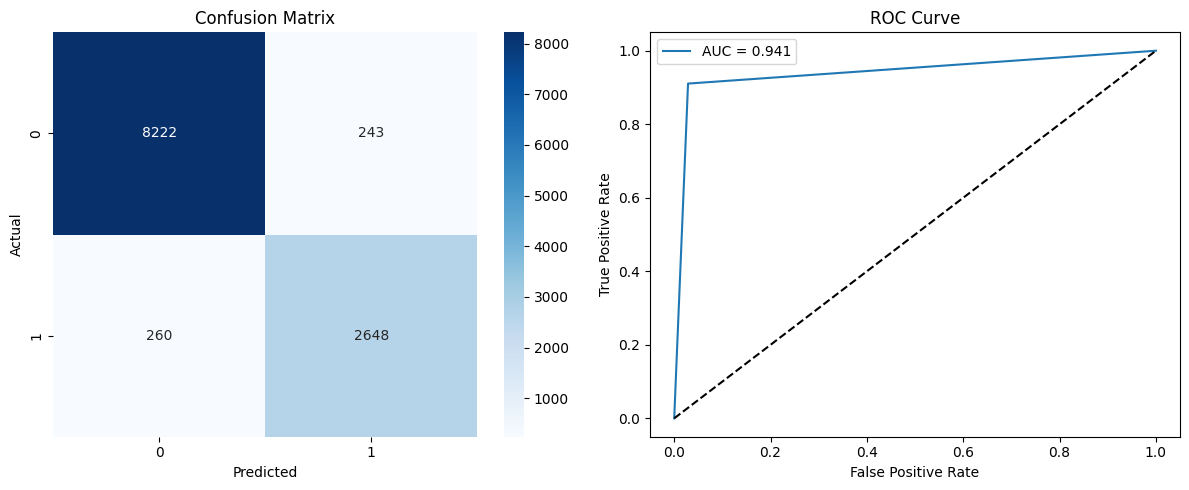

Random Over-Sampling:
Accuracy  : 0.9784  (maximize)
Precision : 0.9633  (maximize)
Recall    : 0.9946  (maximize)
F1 Score  : 0.9787  (maximize)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8494
           1       0.96      0.99      0.98      8461

    accuracy                           0.98     16955
   macro avg       0.98      0.98      0.98     16955
weighted avg       0.98      0.98      0.98     16955



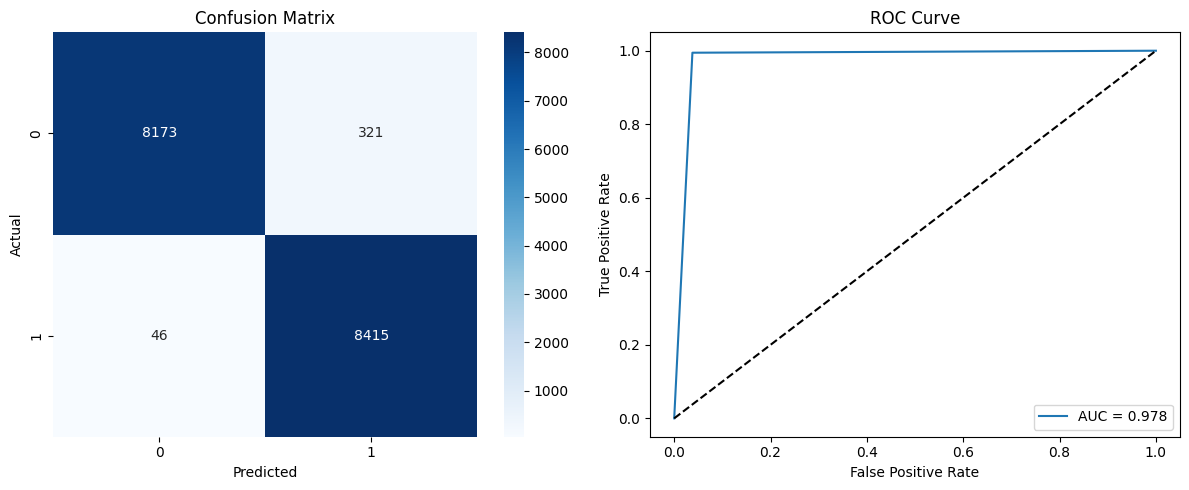

Random Under-Sampling:
Accuracy  : 0.9447  (maximize)
Precision : 0.9350  (maximize)
Recall    : 0.9568  (maximize)
F1 Score  : 0.9457  (maximize)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2876
           1       0.93      0.96      0.95      2915

    accuracy                           0.94      5791
   macro avg       0.95      0.94      0.94      5791
weighted avg       0.94      0.94      0.94      5791



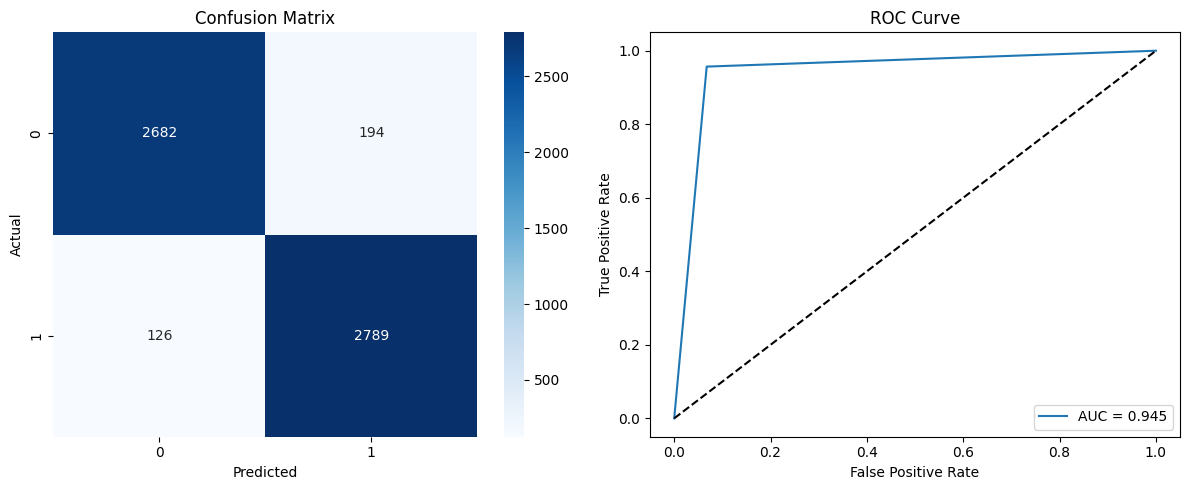

SMOTE Over-Sampling:
Accuracy  : 0.9636  (maximize)
Precision : 0.9598  (maximize)
Recall    : 0.9673  (maximize)
F1 Score  : 0.9636  (maximize)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8509
           1       0.96      0.97      0.96      8446

    accuracy                           0.96     16955
   macro avg       0.96      0.96      0.96     16955
weighted avg       0.96      0.96      0.96     16955



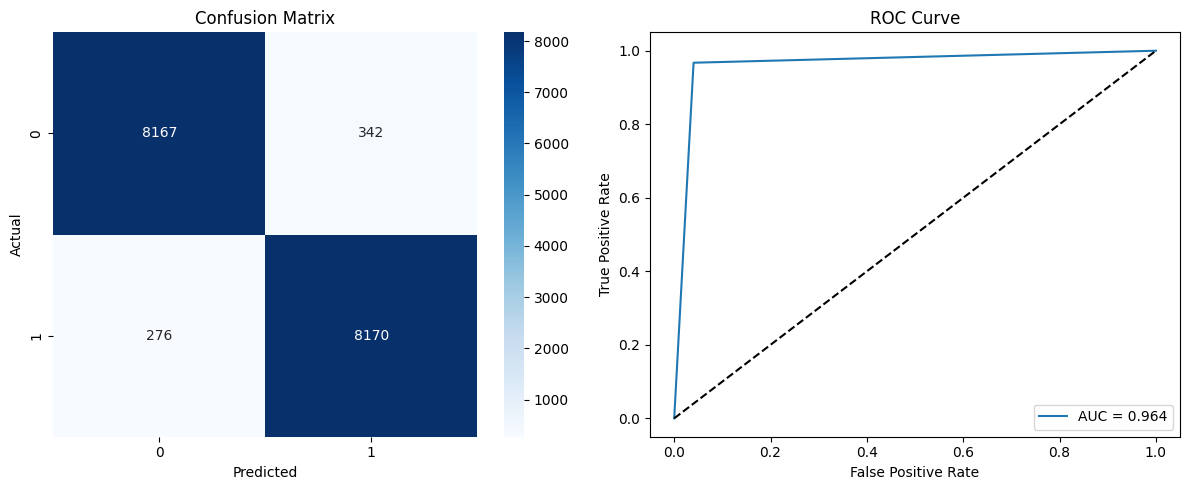

Tomek Links Under-Sampling:
Accuracy  : 0.9581  (maximize)
Precision : 0.9183  (maximize)
Recall    : 0.9212  (maximize)
F1 Score  : 0.9198  (maximize)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8288
           1       0.92      0.92      0.92      2918

    accuracy                           0.96     11206
   macro avg       0.95      0.95      0.95     11206
weighted avg       0.96      0.96      0.96     11206



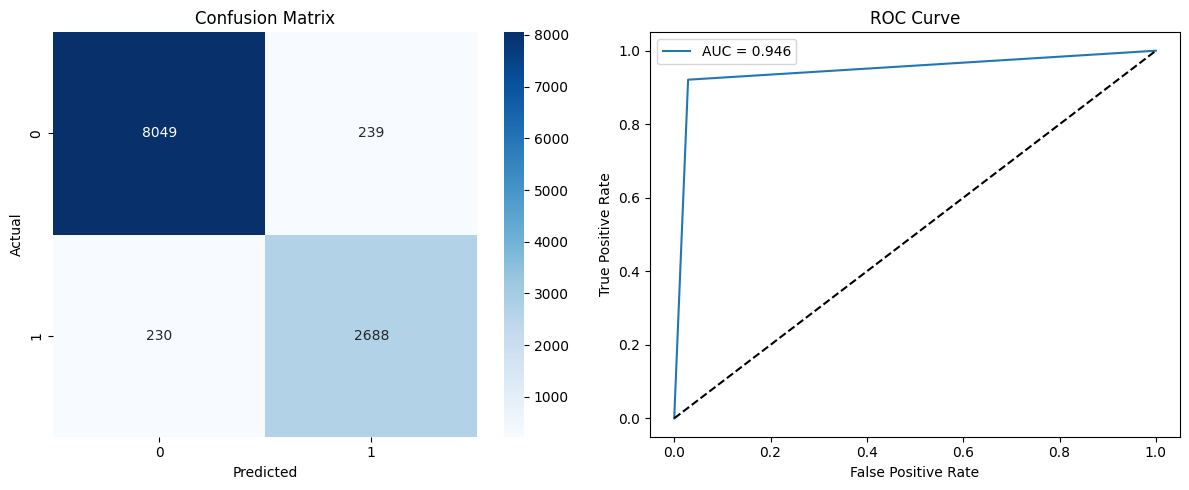

Best sampling method: Random Over-Sampling with ROC AUC: 0.9784
New dataset sizes: Train=67819, Test=16955, Full=84774
Class distribution: class 0: 33893, class 1: 33926


In [7]:
print("Original dataset:")
main(X_df, Y_df)
print("Random Over-Sampling:")
main(*random_over_sample(X_df, Y_df))
print("Random Under-Sampling:")
main(*random_under_sample(X_df, Y_df))
print("SMOTE Over-Sampling:")
main(*smote_over_sample(X_df, Y_df))
print("Tomek Links Under-Sampling:")
main(*tomek_under_sample(X_df, Y_df))

sampled_dataset.print_report("ROC AUC")
X_np_train = sampled_dataset.best_X_train
Y_np_train = sampled_dataset.best_y_train
X_np_test = sampled_dataset.best_X_test
Y_np_test = sampled_dataset.best_y_test

# Parameter Tuning

In [ ]:

search_space = {
    "n_estimators": Integer(50, 200),
    "max_depth": Integer(5, 50),
    "max_features": Real(0.2, 1.0),
    "min_samples_leaf": Integer(1, 20),
    "min_samples_split": Integer(2, 20),
    "criterion": Categorical(["gini", "entropy"])
}
model = RandomForestClassifier()

bayes = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=25,           # number of evaluations
    cv=None,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
)

bayes.fit(X_np_train, Y_np_train)

best_model = bayes.best_estimator_
print(bayes.best_params_)
